In [1]:
import os
import numpy as np  
import pandas as pd
import seaborn as sns
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy

In [2]:
# Change current working directory to the given path
# os.chdir('/Users/rm185431/GL/ML/Recommendation')

In [3]:
header_list = ['userId', 'productId', 'ratings','timestamp']
ratings_data = pd.read_csv('ratings_Electronics.csv', names = header_list)
ratings_data.head(3)

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600


In [4]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
ratings      float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


This dataset contains. 7,842,482 rows with 4 columns

In [5]:
## Check if the dataset has missing values:
ratings_data.isnull().sum()
# The dataset does not have any missing values 

userId       0
productId    0
ratings      0
timestamp    0
dtype: int64

In [6]:
## Check if the dataset is sparse ore dense:
ratings_data.isin([0]).sum()
# The dataset is dense

userId       0
productId    0
ratings      0
timestamp    0
dtype: int64

In [7]:
# Check the number of unique userId and productId
print ('Number of unique productId = ', ratings_data['productId'].nunique())
print ('Number of unique userId    = ', ratings_data['userId'].nunique())

Number of unique productId =  476002
Number of unique userId    =  4201696


In [8]:
# Top 10 users who has given the ratings
ratings_data.groupby('userId').size().sort_values(ascending=False)[:10]

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


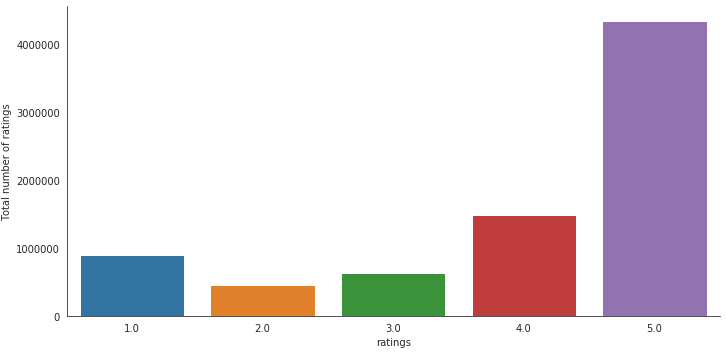

In [9]:
# Plot the distribution of ratings

with sns.axes_style('white'):
    g = sns.factorplot('ratings', data=ratings_data, aspect=2.0, kind='count')
    g.set_ylabels('Total number of ratings')

In [10]:
# Popularity based recommendation (Non personalised)

The frequency of rating 5 is high compared to other ratings

In [11]:
df_by_mean_count = ratings_data.groupby('productId')['ratings'].agg(['mean', 'count'])
# df_by_mean_count = pd.DataFrame(ratings_data.groupby('productId')['ratings'].mean())
# df_by_mean_count['rating_counts'] = pd.DataFrame(ratings_data.groupby('productId')['ratings'].count())
# df_sorted = df_by_mean_count.sort_values(by='count',ascending=False).head()
df_sorted = df_by_mean_count.sort_values(['count','mean'],ascending=[False,False])

# Generate a recommendation rank
df_sorted['rank'] = df_sorted['count'].rank(ascending=False, method='first')

# Get the top 5 recommendations
popularity_based_recommend = df_sorted.head(5)
popularity_based_recommend

,mean,count,rank
productId,,,
B0074BW614,4.491504,18244,1.0
B00DR0PDNE,3.931020,16454,2.0
B007WTAJTO,4.424005,14172,3.0
B0019EHU8G,4.754497,12285,4.0
B006GWO5WK,4.314657,12226,5.0


In [12]:
# Popularity based recommendation model remains same for all users and is not persoonalised

In [13]:
# Take a subset of the dataset to make it less sparse/ denser.
user_counts = ratings_data['userId'].value_counts(ascending=False)
ratings_subset = ratings_data[ratings_data['userId'].isin(user_counts[user_counts > 70].index )]
# user_filtered = user_counts.loc[user_counts.values > 70].index
# ratings_subset = ratings_data.loc(ratings_data.userId.isin(user_filtered))
ratings_subset.count()

userId       75352
productId    75352
ratings      75352
timestamp    75352
dtype: int64

In [14]:
ratings_subset.head(2)

,userId,productId,ratings,timestamp
118,AT09WGFUM934H,0594481813,3.0,1377907200
177,A32HSNCNPRUMTR,0970407998,1.0,1319673600


In [15]:
# Calculate density of the ratings - on average, how many items has each user rated

ratings_matrix = ratings_subset.pivot(index = 'userId', columns = 'productId', values = 'ratings').fillna(0)
print ('Shape of the ratings_matrix : ', ratings_matrix.shape)

num_product_rated = np.count_nonzero(ratings_matrix)
print('Number of ratings given : ', num_product_rated)

possible_num_of_ratings = ratings_matrix.shape[0] * ratings_matrix.shape[1]
print('possible num of ratings : ', possible_num_of_ratings)

density = (num_product_rated / possible_num_of_ratings) * 100
print('Density : {:4.2f}%'.format(density))

# Unique count of product and user on the final dataset
print ('Number of unique productId = ', ratings_subset['productId'].nunique())
print ('Number of unique userId    = ', ratings_subset['userId'].nunique())

Shape of the ratings_matrix :  (669, 32954)
Number of ratings given :  75352
possible num of ratings :  22046226
Density : 0.34%
Number of unique productId =  32954
Number of unique userId    =  669


In [16]:
# Check for the product id that is present in subset

print(ratings_subset.loc[ratings_data['productId'] == '0970407998'])
print(ratings_subset.loc[ratings_data['userId'] == 'AT09WGFUM934H'])

             userId   productId  ratings   timestamp
177  A32HSNCNPRUMTR  0970407998      1.0  1319673600
178  A17HMM1M7T9PJ1  0970407998      4.0  1281744000
                userId   productId  ratings   timestamp
118      AT09WGFUM934H  0594481813      3.0  1377907200
77282    AT09WGFUM934H  B00005105L      5.0  1377475200
160734   AT09WGFUM934H  B000068O1M      5.0  1384905600
160973   AT09WGFUM934H  B000068O34      5.0  1384732800
162248   AT09WGFUM934H  B000068O4J      5.0  1387238400
...                ...         ...      ...         ...
7759167  AT09WGFUM934H  B00HNYDU4Y      5.0  1390867200
7764957  AT09WGFUM934H  B00HSC0D3W      5.0  1397692800
7800249  AT09WGFUM934H  B00ITD5NV6      4.0  1396051200
7809849  AT09WGFUM934H  B00JCABMSI      3.0  1401148800
7819523  AT09WGFUM934H  B00K6YD3B8      4.0  1404864000

[110 rows x 4 columns]


In [17]:
# Split the data randomly into train and test dataset (70/30 ratio).

In [18]:
reader = Reader(rating_scale=(1, 5))
data_knn = Dataset.load_from_df(ratings_subset[['userId', 'productId', 'ratings']], reader=reader)
trainset_knn, testset_knn = train_test_split(data_knn, test_size=.30, random_state=123)
data_knn.df.head()
# print(type(testset_knn))

,userId,productId,ratings
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
631,A3TAS1AG6FMBQW,0972683275,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0


In [19]:
print(trainset_knn.to_inner_uid('A1A5KUIIIHFF4U'))

275


In [20]:
# Viewing the surprise dataset

data_knn.df[(data_knn.df['productId'] == '0970407998')]

,userId,productId,ratings
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0


In [21]:
#  Viewing the test dataset

testset_knn[:5]

[('ANRS196NKFVUU', 'B000O8I474', 5.0),
 ('A3R4794K2RVU1S', 'B0048IW030', 3.0),
 ('AXU3VKZE848IY', 'B001SEQN3U', 5.0),
 ('ARXU3FESTWMJJ', 'B0011000R6', 4.0),
 ('A2JMJVNTBL7K7E', 'B002J9HBIO', 4.0)]

In [22]:
# Build user based Collaborative Filtering model using KNN
from surprise import KNNWithMeans
algo = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset_knn)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [23]:
# Query for specific predicions
uid = str('AT09WGFUM934H')  # raw user id
iid = str('0970407998')  # raw item id
# get a prediction for specific user id and item id.
pred_knn = algo.predict(uid, iid, verbose=True)

user: AT09WGFUM934H item: 0970407998 r_ui = None   est = 4.32   {'actual_k': 0, 'was_impossible': False}


In [24]:
# Get the estimated rating
print('Predicted rating : ' , pred_knn.est)
print('Actual k         : ' , pred_knn.details['actual_k'])

Predicted rating :  4.32051282051282
Actual k         :  0


In [25]:
# run the trained model against the testset
test_pred_knn = algo.test(testset_knn)
test_pred_knn

[Prediction(uid='ANRS196NKFVUU', iid='B000O8I474', r_ui=5.0, est=4.875, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3R4794K2RVU1S', iid='B0048IW030', r_ui=3.0, est=4.583333333333333, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AXU3VKZE848IY', iid='B001SEQN3U', r_ui=5.0, est=3.5648863148863144, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='ARXU3FESTWMJJ', iid='B0011000R6', r_ui=4.0, est=3.6831683168316833, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2JMJVNTBL7K7E', iid='B002J9HBIO', r_ui=4.0, est=3.564516129032258, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1L64KDYO5BOJA', iid='B0019UGCLG', r_ui=4.0, est=4.432098765432099, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2IFKH3TJ10387', iid='B009WE65EA', r_ui=5.0, est=4.4363636363636365, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2NYK9KWFMJV4Y', iid='B00HVMIL1U', r_ui=4.0

In [26]:
# Get the list of users who have not rated any products

pred_knn_df = pd.DataFrame(test_pred_knn)
pred_knn_df['was_impossible'] = [temp['was_impossible'] for temp in pred_knn_df["details"]]
# pred_knn_df[(pred_knn_df['was_impossible']==True)]

In [27]:
# get RMSE
print("User-based Model with KNNWithMeans : Test Set")
accuracy.rmse(test_pred_knn, verbose=True)

User-based Model with KNNWithMeans : Test Set
RMSE: 1.0401


1.040054955727394

In [28]:
# Build Collaborative Filtering model using Singular Value decomposition

# Matrix factorization aligns user to a set of latent features, 
# and fits product into some set of latent features.

# SVD is best for applying on large sparse datasets

In [29]:
reader = Reader(rating_scale=(1, 5))
data_svd = Dataset.load_from_df(ratings_subset[['userId', 'productId', 'ratings']], reader=reader)
trainset_svd, testset_svd = train_test_split(data_svd, test_size=.30, random_state=123)
data_svd.df.head()

,userId,productId,ratings
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
631,A3TAS1AG6FMBQW,0972683275,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0


In [30]:
svd_model = SVD(n_factors=50, biased=False)
svd_model.fit(trainset_svd)

In [31]:
# Query for specific predicions
uid = str('AT09WGFUM934H')  # raw user id
iid = str('B006W8U2MU')  # raw item id
# get a prediction for specific user id and item id.
pred_knn = svd_model.predict(uid, iid, verbose=True)

user: AT09WGFUM934H item: B006W8U2MU r_ui = None   est = 3.35   {'was_impossible': False}


In [32]:
# run the trained SVC model against the testset
test_predict_svd = svd_model.test(testset_svd)
pred_svd_df = pd.DataFrame(test_predict_svd)
pred_svd_df['was_impossible'] = [temp['was_impossible'] for temp in pred_svd_df["details"]]
pred_svd_df.loc[pred_svd_df.was_impossible].head()

,uid,iid,r_ui,est,details,was_impossible
8,A1C5WS021EL3WO,B00BY3XN7E,5.0,4.260001,"{'was_impossible': True, 'reason': 'User and i...",True
12,A7QMQBGJ2TCQG,B000ZPJEDE,2.0,4.260001,"{'was_impossible': True, 'reason': 'User and i...",True
13,A27ADCSD15F3GL,B00E20SSWQ,2.0,4.260001,"{'was_impossible': True, 'reason': 'User and i...",True
14,A2AF0NOCM71J0B,B008DBI6Y0,4.0,4.260001,"{'was_impossible': True, 'reason': 'User and i...",True
15,AS269J1OGZT1V,B006OSQALU,3.0,4.260001,"{'was_impossible': True, 'reason': 'User and i...",True


In [33]:
# Compute RMSE

print("User-based Model with SVD : Test Set")
accuracy.rmse(test_predict_svd, verbose=True)

User-based Model with SVD : Test Set
RMSE: 2.0301


2.0300756349578464

Since the RMSE of SVD is higher than KNNMeans, using KNNMeans for recommendation

Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [34]:
# Making Recommendations:

# Get the list of product ids

from collections import defaultdict
 
def get_top5_recommendations(predictions, topN = 5):
     
    top_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_recs[uid].append((iid, est))
     
    for uid, user_ratings in top_recs.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_recs[uid] = user_ratings[:topN]
    return top_recs


In [35]:
# Making Recommendations for a userId:
def recommend_for_user(userId):
    top5_recommendations = get_top5_recommendations(test_pred_knn)
    for uid, user_ratings in top5_recommendations.items():
        if (uid == userId):
            print(f"Top 5 product recommendation for userId {uid} - products {user_ratings} ")

In [36]:
recommend_for_user('AT09WGFUM934H')

Top 5 product recommendation for userId AT09WGFUM934H - products [('B006W8U2MU', 5), ('B005CT56F8', 4.8992140119592795), ('B00F4JOP0S', 4.674679487179487), ('B00BQ4F9ZA', 4.641941391941391), ('B002DUKPN2', 4.32051282051282)] 


# Summarise my insights:
Popularity based recommendation systems can be used for users who do not have a profile and does not have the purchasing behavour data.

With Collaborative filtering, each user receives personalized product recommendations based on how they rated other products they have bought/used.
One of the major weaknesses of collaborative filtering is known as the cold-start problem: How do we make recommendations to new users whom we have little to no data about their preferences? Since we have no information about the user’s preferences, we cannot accurately compute the similarity between the new user and more established users.

For cold-start problem, content based recommendation will be a suggested approach.